## Домашнее задание №4

In [1]:
import matplotlib.pyplot as plt
import random
from matplotlib.colors import ListedColormap
from sklearn import datasets
import numpy as np
from sklearn.model_selection import train_test_split

1. В коде из методички реализуйте один или несколько критериев останова (количество листьев, глубина дерева и т.д.).

In [2]:
# Реализуем класс узла
class Node:

    def __init__(self, index, t, true_branch, false_branch, node_level):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
        self.node_level = node_level + 1  # depth, level
    
    def print(self):
        print(f"{self.__class__.__name__} Индекс={self.index} Порог={self.t} Глубина={self.node_level}")

In [3]:
# класс терминального узла (листа)
class Leaf:

    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()

    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его
        prediction = max(classes, key=classes.get)
        return prediction

    def print(self):
        print(f"{self.__class__.__name__} objects: {len(self.data)} labels: {self.labels}")

In [4]:
# Расчет критерия Джини
def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1

    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2

    return impurity


# Расчет качества
def quality(left_labels, right_labels, current_gini):
    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)


# Разбиение датасета в узле
def split(data, labels, index, t):
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)

    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]

    return true_data, false_data, true_labels, false_labels


# Нахождение наилучшего разбиения
def find_best_split(data, labels, min_leaf: int = 5):
    #  обозначим минимальное количество объектов в узле    # min_leaf = 5
    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None

    n_features = data.shape[1]

    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])

        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue

            current_quality = quality(true_labels, false_labels, current_gini)

            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index


# Построение дерева с помощью рекурсивной функции
def build_tree(data, labels, min_leaf: int = 5, max_depth: int = None):
    quality, value, index = find_best_split(data, labels, min_leaf)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    #  прекращаем рекурсию, got max_depth
    if max_depth is not None:
        if max_depth == 0:
            return
        max_depth -= 1

    true_data, false_data, true_labels, false_labels = split(data, labels, index, value)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, min_leaf, max_depth)
    false_branch = build_tree(false_data, false_labels, min_leaf, max_depth)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, value, true_branch, false_branch, max_depth)


def classify_object(obj, node):
    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)


def predict(data, tree):
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):
    if node is None:
        return
    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing, node.print(), "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога, Глубина на этом узле
    print(spacing, node.print())

    # Рекурсионный вызов функции на положительном поддереве
    print(spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print(spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    return


# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0


# Визуализируем дерево на графике
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

In [5]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification( 
                                                      n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant = 0, 
                                                      n_clusters_per_class = 1, 
                                                      random_state = 21
                                                                         )

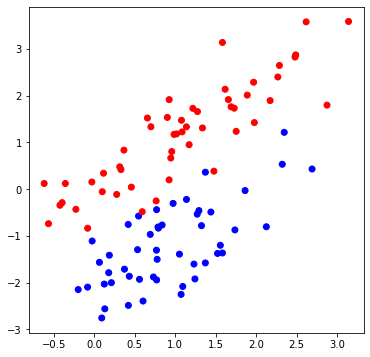

In [6]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(6,6))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [7]:
# Разобьем выборку на обучающую и тестовую
train_data, test_data, train_labels, test_labels = train_test_split(classification_data,
                                                                                    classification_labels,
                                                                                    test_size=0.3,
                                                                                    random_state=1)

Критерии останова

In [8]:
leaf_param = 8
depth_param = 5 

In [9]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, leaf_param, depth_param)

print_tree(my_tree)

# Получим ответы для обучающей выборки
train_answers = predict(train_data, my_tree)

# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print("train_accuracy", train_accuracy)

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
print("test_accuracy", test_accuracy)

Node Индекс=1 Порог=-0.44036359574177864 Глубина=5
 None
--> True:
Node Индекс=1 Порог=-0.7828775027800934 Глубина=4
   None
  --> True:
Leaf objects: 24 labels: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
     None Прогноз: 1
  --> False:
Leaf objects: 8 labels: [0 1 1 1 1 1 1 0]
     None Прогноз: 1
--> False:
Node Индекс=1 Порог=1.2148685809533477 Глубина=4
   None
  --> True:
Node Индекс=0 Порог=0.4565440387207208 Глубина=3
     None
    --> True:
Leaf objects: 9 labels: [0 0 0 0 0 0 0 0 0]
       None Прогноз: 0
    --> False:
Leaf objects: 9 labels: [1 1 0 0 1 1 0 1 1]
       None Прогноз: 1
  --> False:
Leaf objects: 20 labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
     None Прогноз: 0
train_accuracy 92.85714285714286
test_accuracy 80.0


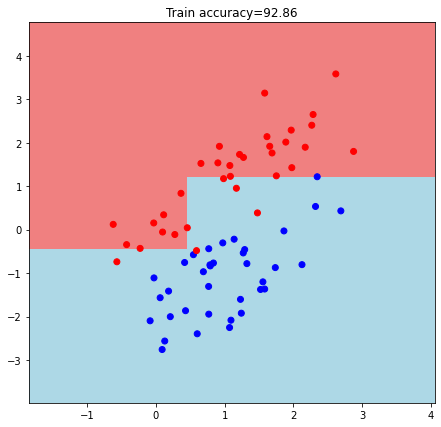

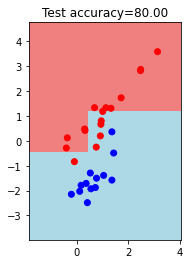

In [10]:
plt.figure(figsize=(16, 7))

# график обучающей выборки
plt.subplot(1, 2, 1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors, shading='auto')
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, cmap=colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')
plt.show()

# график тестовой выборки
plt.subplot(1, 2, 2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors, shading='auto')
plt.scatter(test_data[:, 0], test_data[:, 1], c=test_labels, cmap=colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')
plt.show()

2. Для задачи классификации обучите дерево решений с использованием критериев разбиения Джини и Энтропия. Сравните качество классификации, сделайте выводы.

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.tree import DecisionTreeClassifier

In [12]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification( 
                                                      n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant = 0, 
                                                      n_clusters_per_class = 1, 
                                                      random_state = 21
                                                                         )

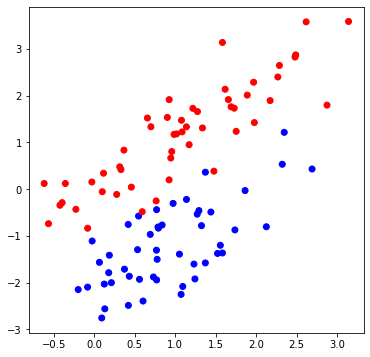

In [13]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(6,6))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [14]:
clf_gini = DecisionTreeClassifier(random_state=42, criterion='gini', max_depth=depth_param, min_samples_split=leaf_param )
cross_val_score(clf_gini, classification_data, classification_labels, cv=10)

array([0.8, 0.9, 1. , 0.9, 1. , 0.7, 0.8, 0.9, 0.8, 0.8])

In [15]:
clf_entropy = DecisionTreeClassifier(random_state=42, criterion='entropy', max_depth=depth_param, min_samples_split=leaf_param )
cross_val_score(clf_entropy, classification_data, classification_labels, cv=10)

array([0.8, 0.9, 0.9, 1. , 1. , 0.8, 0.8, 0.9, 0.8, 0.9])

При выбранных параметрах выборки:
- 1000 обéктов,
- max_depth=depth_param=8
- min_samples_split=5

Выбранные критерии качества дают примерно одинаковый результат